Hi! This is a walk-through of my approach to the Kaggle competition 'TMDB Box Office Prediction' where the objective is to predict the worldwide box-office revenue of a given movie using data from the ['The Movie DataBase'](http://www.themoviedb.org/). 
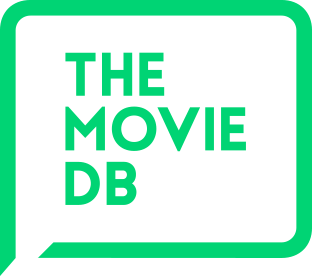

**Motivation** - I found this particular competition highly motivating since it's a question that goes on in every production studio head honcho's mind while pumping millions into making a movie. "*Will this movie work?*" It's an age old question across film industries throughout the world and one that no one really has the answer to. Be it USA, India, China, France or South Korea - the dilemma is universal. You'd probably imagine getting in an A-list actor, a multi-million dollar budget, a flooded star cast or a popular genre would lead to the film undoubtedly be a success. 
But what about the gender ratio of the crew? Or the existence of the movie homepage on the internet? Could these be factors in possibly predicting the money a movie makes? So let's hope we uncover some interesting insights and dive right into it!
I will try to explain each of my steps as we go along and why I'm doing what I'm doing as best I can. 


Let's get started by importing some typical libraries which might be useful as we work towards a solution. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import os 
warnings.filterwarnings("ignore")

We load the training data stored in train.csv into a Pandas dataframe. And let's get a sense of what the data looks like by printing the first 5 rows.   

In [ ]:
os.chdir('../input/tmdb-box-office-prediction/')
train = pd.read_csv('train.csv')
train.head()

As we can see above, we have 23 columns - 22 input features and 1 output feature - the revenue. The following is a brief description of each feature. It helps to go read and re-read this again and really know what you're dealing with and develop some intuition about how to deal with the data. What features might be crucial, how we can translate some features into ones and if we could combine some features to eliminate redundancy. 

**List** - 

**id** - Integer unique id of each movie

**belongs_to_collection** - Contains the TMDB Id, Name, Movie Poster and Backdrop URL  of a movie in JSON format. You can see the Poster and Backdrop Image like this: https://image.tmdb.org/t/p/original/<Poster_path_here>. Example: https://image.tmdb.org/t/p/original//iEhb00TGPucF0b4joM1ieyY026U.jpg

**budget**:Budget of a movie in dollars. 0 values mean unknown. 

**genres** : Contains all the Genres Name & TMDB Id in JSON Format

**homepage** - Contains the official homepage URL of a movie. Example: http://sonyclassics.com/whiplash/	, this is the homepage of Whiplash movie.

**imdb_id** - IMDB id of a movie (string). You can visit the IMDB Page like this: https://www.imdb.com/title/<imdb_id_here>

**original_language** - Two digit code of the original language, in which the movie was made. Like: en = English, fr = french. 

**original_title** - The original title of a movie. Title & Original title may differ, if the original title is not in English. 

**overview** - Brief description of the movie.

**popularity** -  Popularity of the movie in float. 

**poster_path** - Poster path of a movie. You can see the full image like this: https://image.tmdb.org/t/p/original/<Poster_path_here>

**production_companies** - All production company name and TMDB id in JSON format of a movie.

**production_countries** - Two digit code and full name of the production company in JSON format.

**release_date** - Release date of a movie in mm/dd/yy format.

**runtime** - Total runtime of a movie in minutes (Integer).

**spoken_languages** - Two digit code and full name of the spoken language. 

**status** - Is the movie released or rumored? 

**tagline** - Tagline of a movie 

**title** - English title of a movie

**Keywords** - TMDB Id and name of all the keywords in JSON format. 

**cast** - All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format

**crew** - Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc. 

**revenue** - Total revenue earned by a movie in dollars. 

In [ ]:
test = pd.read_csv('./test.csv')
test.head()

As you can see, the test dataframe is similar to the train dataframe except that it has one column less, which is the revenue column which in turn is what we're supposed to predict after training the model with our training data. 

To further get to know your data-set, it's always a great idea to use info() so you know the number of missing values and the dtype of each of your features. 

In [ ]:
print(train.info())
print(test.info())

Another standard step of your Exploratory Data Analysis would be to use the describe() function which is an essential feature of the Pandas library giving us important statistical information about our features. This gives us a bird's eye view of our data and a quantitatively better idea using the central measures of dispersion. This would mainly only apply to numerical data though. 

In [ ]:
train.describe(include = 'all')

For example, at first glance, on seeing the 'budget' column, we see that the mean budget is around 22.5 million whereas the median is around 8 million and the mean is actually closer to the 75 percentile value (3rd quartile) (around 29 million). So you can see how the mean is skewed by outlier data points in the budget column. 


In [ ]:
test.describe(include = 'all')

Before we begin with our analysis, we will have to combine our training and test dataframe into one. This is being done to smoothly create new features during feature engineering where the same features will have to be created for both the train and the test set. 
What we will need to be careful with though is to prevent information leakage from the test set. Remember, the model is to be trained SOLELY on the the training data and nothing else. No information from the test set can be used while building new features. All the processing will be done using the training data only. While creating new features however, the new feature will be created for both the training and test set to ensure they have the same dimensions. What we can do is add create feature for train set and then mimic the same code for test set after that. I prefer to do the operation on our combined dataset so the same feature gets created for both.  

In [ ]:
revenue = train['revenue']
train.drop(columns = ['revenue'], axis=1, inplace = True)

combined = train.append(test)
combined.reset_index(inplace = True, drop = True)

combined

Perfect! We have created a combined dataset of both the train and test set. The number of rows are the sum of the train and test set. Notice how we have 22 columns. That's because we dropped the revenue column from the train set but we've stored it in the variable 'revenue' for later use. 

**BUDGET**

Now that we have a sense of what our data looks like, it would be a good time to visualize the relation between features which we think are correlated.

The most obvious choice that came to mind was seeing the relation between budget and revenue as you'd expect there would be a direct relation between budget and revenue. For this, we use the seaborn library. 

But before that, let's look a little deeper into the distribution of the revenue variable. 

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(revenue)

We can see that the revenue curve looks similar to an exponential distribution with a large majority of the data concentrated for revenues less than 200 million. 

Let's now look at the relation between the film budget and revenue. 

In [ ]:
plt.figure(figsize = (20,10))
sns.scatterplot(x = train['budget'], y = revenue)

We see that the plot shows a slight positive correlation between budget and revenue. Probably only for budgets > 100 million, there is a more linear relation to revenue. But for smaller budgets, the relation is not that strong. 

Anyway, the budget is a continuous numerical variable that describes precisely well, the budget of the movie. So no additional processing is needed here. 

**Release Date**

Notice we have the feature 'release date' in the format MM/DD/YY. To extract more information out of this feature and create more insight into predicting movie revenue, we can split this up into release year, release month and release day. That we can try finding trends between revenue vs release year, month or day of the month. So hence we split up this feature to create three new features. 
Also note that, the year is in the form YY so to convert to proper form, we add 1900 when YY is less than 19 since we know there is no movie in our database that was released before 1919 so any movie that has values between 0 to 19 has to have been released between 2000 and 2019 and not before. And for YY > 19, we add 1900 as a result. 

In [ ]:
combined[['release_month','release_day','release_year']] = combined['release_date'].str.split('/', expand = True).replace(np.nan,-1).astype(int)

combined.loc[ (combined['release_year'] > 19), "release_year"] += 1900
combined.loc[ (combined['release_year'] <= 19), "release_year"] += 2000
combined[['release_day','release_month','release_year']]

We can also make use of pd.to_datetime to convert our 'release date' column to standard pandas DateTime format so we can extract further information from this. Knowing what exact date it was, we can then create two new columns telling us what day of the week the movie released and what quarter it was. So let's do that then. 

Note - In release_dayofweek, the values go from 0-6 where 0 is Monday to 6 is Sunday. 

In [ ]:
releaseData = pd.to_datetime(combined['release_date'])
combined['release_dayofweek'] = releaseData.dt.dayofweek
combined['release_quarter'] = releaseData.dt.quarter
combined.head()

There we have it. 5 useful extra columns from the release date feature. Now that we have extracted this information, we can drop the original release date feature. 

In [ ]:
combined.drop(columns = ['release_date'], axis = 1, inplace = True)

In [ ]:
combined.columns

As we can see, the original feature is not there anymore. 

With our new-found features, we have the ability to extract some interesting insights and trends with the distribution of movies released based on release time. Let's first visualize the number of movies released per year. 

In [ ]:
plt.figure(figsize = (20,10))
sns.countplot(combined['release_year'][:3000])
plt.xticks(rotation=90)
plt.show()

As expected, the basic trend is that the number of released movies increases year by year. The slump at 2017 can probably be attributed to incomplete records of movives in the entire year of 2017.  

In [ ]:
plt.figure(figsize = (20,12))
sns.countplot(combined['release_month'][:3000])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
loc, labels = plt.xticks()
plt.xticks(loc, months, fontsize = 10)
plt.show()

The number of movies released per month is quite equally spread out with a peak in the month of September. I don't know if that's representative of films in general or if it's just our data since our data isn't exactly sizeable enough. 

In [ ]:
plt.figure(figsize = (20,12))
sns.countplot(combined['release_day'][:3000])
plt.xticks(rotation=90)
plt.show()

So, the most movies are released on the 1st of the month according to our data. Again, I don't know if that's representative of films in general. But otherwise, the numbers are pretty evenly distributed. The low number on 31st can be attributed to some months not having a 31st date. 

In [ ]:
plt.figure(figsize = (20,12))
sns.countplot(combined['release_dayofweek'][:3000])
loc, labels = plt.xticks()
labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.xticks(loc, labels, fontsize = 10)
plt.show()

As expected, the vast majority of movies release on a Friday. Methods like these can be used to self-verify some processes in the way that seeing this data, we verified our release_dayofweek extraction. 

In [ ]:
plt.figure(figsize = (20,12))
sns.countplot(combined['release_quarter'][:3000])
loc, labels = plt.xticks()
labels = ['Q1','Q2','Q3','Q4']
plt.xticks(loc, labels, fontsize=10)
plt.show()

Pretty evenly spread across quarters with a slightly larger number of movies being released in the second half of the year. 

I now want to visualize the relation between our target variable - revenue and our newly created features. For this, I create a temporary df 'temp' where I put revenue back in order to visualize the below relationships. 

In [ ]:
temp = pd.concat([combined[:3000],revenue],axis=1)

Let's visualize the mean movie revenue by year. 

In [ ]:
temp['meanRevenueByYear'] = temp.groupby('release_year')['revenue'].aggregate('mean')
temp['meanRevenueByYear'].plot(figsize=(15,10),color="g")
plt.xlim(1920,2018)
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Year",fontsize=20)
plt.show()

From this visualization, it's quite interesting that film revenues peaked in the late 1970s and then quickly dipped after that only reaching similar numbers in the early 2000s. It's also worth noting that our mean revenue is oscillating year-by-year and that there is no steady year-by-year increase in revenue. 

In [ ]:
temp['meanRevenueByMonth'] = temp.groupby("release_month")["revenue"].aggregate('mean')
temp['meanRevenueByMonth'].plot(figsize=(15,10),color="g")
plt.xlabel("Release Month")
plt.ylabel("Revenue")
plt.xlim(1,12)
plt.title("Movie Mean Revenue Release Month",fontsize=20)
plt.show()

This is probably one of my favourite visualizations where we self confirm some things that we know to be true. The biggest movies mostly release in the summer or the end of the year! 

In [ ]:
temp['meanRevenueByDayOfWeek'] = temp.groupby("release_dayofweek")["revenue"].aggregate('mean')
temp['meanRevenueByDayOfWeek'].plot(figsize=(15,10),color="g")
plt.xlabel("Day of Week")
plt.ylabel("Revenue")
plt.xlim(0,7)
plt.title("Movie Mean Revenue by Day of Week",fontsize=20)
plt.show()

Very surprisingly, the mean revenue is largest for movies released on Wednesdays and Thursdays (3 and 4). This might even be attributed to the small number of movies released on these days and a disproportionate sample of movies in our data as a result. But I do wonder if this finding holds true for movies in general too. 

In [ ]:
temp['meanRevenueByQuarter'] = temp.groupby("release_quarter")["revenue"].aggregate('mean')
temp['meanRevenueByQuarter'].plot(figsize=(15,10),color="g")
plt.xlabel("Quarter")
plt.ylabel("Revenue")
plt.xlim(1,4)
plt.title("Movie Mean Revenue by Quarter",fontsize=20)
plt.show()

Well, it looks like the highest earning movies get released in the 2nd quarter (April-June). 

**Genres**

Let's now look at another very important variable that may also arguably have the largest effect on box-office revenue - the genre. To think of going to the cinema to watch a movie, one would probably want to know what kind of genre the movie falls under and that plays a massive role in knowing how well a movie is going to do. Be it drama, action, fantasy, thriller, comedy - each genre creates an image and an expectation in the audience for what to expect. 

In our training set, we have the 'genres' column in JSON format where from a Python perspective, you can view it as a list of dictionaries where each dictionary contains two key-value pairs: one for 'id' and one for 'name'. Expectedly, some movies might have only one genre defined whereas others have multiple ones. What we'll do in the below code is extract the genres from each entry and finally create columns corresponding to each genre so as to convert this categorical information to more analyzable quantitative data. 

Below, we find out which movie IDs have missing values in the 'genre' column. 

In [ ]:
df_genres_na = combined['genres'].isna()
na_id = []
for i in combined['id'][df_genres_na]:
    na_id.append(i)
print('The list of Movie IDs that have missing genres are',na_id)    

While working with the data, I realized that while reading data from the CSV file into the pandas DF, my 'genres' column has been converted into a string where ideally it should have been interpreted as a list of dictionaries. To change that, I use the literal_eval function to interpret the 'genre' entries as Python lists of dictionaries. 

In [ ]:
from ast import literal_eval
for i in range(len(combined['genres'])):
    if i+1 not in na_id:
        combined['genres'][i] = literal_eval(combined['genres'][i])

In [ ]:
out = {}
l = []
for i in range(len(combined['genres'][:])):
    if i+1 not in na_id:
        for d in combined['genres'][i]:
            for key,val in d.items():
                if key == 'name':
                    l.append(val)
        out[i+1] = l
        l = []
        
for i in na_id:
    out[i] = ['Drama']

In the below code, we use multiple string operations to convert our JSON data into the most usable form. I have tried using basic Python string functions to make the code more readable and more intuitive to understand the data manipulation at play. The aim was to convert each entry to one that only contains their genres seperated by a space so that we can directly use the get_dummies function to create a one-hot encoding column for each unique genre. 

Below, I also create a word cloud that gives us a real good sense of how common each genre is. 

In [ ]:
from wordcloud import WordCloud
combined_genres = pd.Series(data = out, index = out.keys())
combined_genres.sort_index(inplace = True)

for i in range(1,len(combined_genres)+1):
    combined_genres[i] = str(combined_genres[i])[1:-1]
    combined_genres[i] = combined_genres[i].replace(' ','')
    combined_genres[i] = combined_genres[i].replace('\'','')
    combined_genres[i] = combined_genres[i].replace(',',' ')
    
word_cld = combined_genres[:3000]
text = ''
for i in range(1,len(word_cld)+1):
    word_cld[i] = word_cld[i].replace(',',' ')
    text = text + ' ' + word_cld[i]
        
wc = WordCloud(background_color = 'white', collocations = False, height  = 800, width = 1600).generate(text)
plt.figure(figsize = (15,15))
plt.title('Top Movie Genres')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

As we can see in the Word Cloud above, it looks like Drama and Comedy followed by Thriller and Action are the most common genres in our data. This is pretty representative of films in general too and so we can say our data set samples overall film genre data considerably well. 

Here is where we use combined_genres to create our one-hot encoding columns correspdonding to each unique genre. This needs to be done to convert our categorical information into numeric so we can easily train our data into the model. As you can see below, new columns are created corresponding to the genre. For each row, there will be a 1 in a genre column if the genre exists for that movie and 0 otherwise. 

In [ ]:
combined_genres = combined_genres.reset_index(drop = True)
combined_genres_df = combined_genres.str.get_dummies(sep = ' ')
combined = pd.concat([combined,combined_genres_df], axis = 1)
combined.drop(['genres'], axis = 1, inplace = True)
combined.columns

As we can see, the new binary valued genre columns correspdonding to each unique genre have been added to the combined dataframe and we do not need the original genres feature anymore.  

**Production Companies**

Let's move onto our next feature - Production companies. In my opinion, this probably ranks among the top 5 features to predict the movie revenue atleast from an intuitive sense. Seldom do you see movies that make big bucks that are not backed by a major production house. Movies made by major production studios often have considerably large budgets as well and are geared towards making large profits. 

Another factor is that these movies have large marketing and advertising budgets which come from the production studio and these in turn lead to more people coming to the theatre while small studios or indie movies don't have that kind of luxury. 

Let's follow a similar process as we did for extracting genres out of the column. 

In [ ]:
df_prod_comp_na = combined['production_companies'].isna()
na_id_prod_comp = []
for i in combined['id'][df_prod_comp_na]:
    na_id_prod_comp.append(i)

In [ ]:
for i in range(len(combined['production_companies'])):
    if i+1 not in na_id_prod_comp:
        combined['production_companies'][i] = literal_eval(combined['production_companies'][i])

train['production_companies'] = combined.loc[:3000,'production_companies']        

Note that I have duplicated the converted list items in 'combined' - production companies to 'train' - production companies.   

Find all the rows where 'production companies' column is not NA. 

In [ ]:
X = train['production_companies'].notna()

Notice how I'm using the train dataframe here. This is because I cannot take information that is being used to create a feature from the test set. We should be only using the training set for processing and feature engineering purposes and while only creating the new feature, it should be created on both sides. For the same reason, I will be using the train dataset instead of combined below. Since I don't want to use any information from the test set to create new features.

Here, we are extracting the production company names from the dictionary by taking value of key = 'name'.  

In [ ]:
list_of_companies = list(train['production_companies'][X].apply(lambda x: [i['name'] for i in x] if x != "" else []).values)

Let's see the 15 most common production companies in our training dataset! 

In [ ]:
from collections import Counter
top_prod_comp = Counter([i for j in list_of_companies for i in j]).most_common(15)
top_prod_comp


As we can see, the usual suspects are in the list. The big guns, the premiere movie making studios of Hollywood. The Disneys, The Foxes, the WBs, etc. These studios are mostly behind the biggest blockbusters ever made in cinema. It is worth noting again that this data is representative of films in general. 

Other than getting some findings about the production company data, the idea behind taking the 15 most common production companies is so we can create 15 columns corresponding to each company. In the case of genres, we could do this for all the genres present as there was a small number of them. Here, the number of unique production studios were approximately 7000 which makes it nonsensical to create a one-hot column for each. So we select the 15 most common studios and create a column for each. 

In [ ]:
X = combined['production_companies'].notna()
combined['all_production_companies'] = combined['production_companies'][X].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for i in range(len(combined['all_production_companies'])):
    if i+1 in na_id_prod_comp:
        combined['all_production_companies'][i] = 'Missing' 
    
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(15)]
for g in top_companies:
    combined['Prod_Comp_' + g] = combined['all_production_companies'].apply(lambda x: 1 if g in x else 0)

combined

To make sure the right columns are in my dataframe, I usually take a quick glance at the columns list to check if my step-by-step progress is as intended. 

In [ ]:
combined.columns

So as we can see, we have 15 new columns with 'Prod_Comp_' prefixed before each Production Company name. We won't be needing the 'all_production_companies' column and the original JSON 'production_companies' column now so we drop it from our combined dataframe.  

In [ ]:
combined.drop(columns = ['production_companies','all_production_companies'], axis = 1, inplace = True)

**Production Countries**

Moving onto our next feature - Production countries. This is also in JSON format and hence we will follow a similar pattern of extracting the data like genre and production company. I'm not sure how the correlation between production country and revenue would be. But I expect a large number of production countries to correspond to USA. 

In [ ]:
df_prod_cntry_na = combined['production_countries'].isna()
na_id_prod_cntry = []
for i in combined['id'][df_prod_cntry_na]:
    na_id_prod_cntry.append(i)

for i in range(len(combined['production_countries'])):
    if i+1 not in na_id_prod_cntry:
        combined['production_countries'][i] = literal_eval(combined['production_countries'][i])

train['production_countries'] = combined.loc[:3000,'production_countries']


In [ ]:
X = train['production_countries'].notna()
list_of_countries = list(train['production_countries'][X].apply(lambda x: [i['name'] for i in x] if x != "" else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)

As expected! Around 75% of the movies in the data-set have USA as their production country which could be attributed to the large number of Hollywood movies in the data. The number of films having other production countries are very small and what would make sense would be to create a new feature only telling us whether the movie was shot in USA and not having a seperate column for each production country. So we have essentially divided the data into US and non-US in this aspect after seeing the disproportionately high number of movies shot in USA. 

In [ ]:
X = combined['production_countries'].notna()
combined['all_countries'] = combined['production_countries'][X].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(1)]
for g in top_countries:
    combined['production_country_' + g] = combined['all_countries'][X].apply(lambda x: 1 if g in x else 0)
combined.head(5)

As we can see, a new column indicating movie production country in USA or not has been added to our dataframe. Since we have this, we won't be needing the 'all_countries' column and the original 'production_countries' column. 

In [ ]:
combined.drop(columns = ['all_countries','production_countries'], axis = 1, inplace = True)

**Cast**

What's the first thing you do when you hear of a movie? Log onto Google and see who's in it ofcourse! That's where the cast comes in. The faces you see on the big screen, playing characters and immersing the audience into their world with their immense acting prowess. 

Some of these stars have the power to make the movie millions of dollars on their own. These stars have a fanbase that spans across the world and have acquired a reputation through decades of work in the industry. The general feeling is that one is less likelier to go watch a movie when the cast is unrecognizable. Sometimes, it doesn't even matter what the movie is about - as long as your favourite actor in it. Am I right? Therefore, I feel the cast has a vital role in predicting movie success.    

The 'cast' column is in JSON format too and we use a similar process as before in extracting relevant data. 

In [ ]:
df_cast_na = combined['cast'].isna()
na_id_cast = []
for i in combined['id'][df_cast_na]:
    na_id_cast.append(i)

for i in range(len(combined['cast'])):
    if i+1 not in na_id_cast:
        combined['cast'][i] = literal_eval(combined['cast'][i])

train['cast'] = combined.loc[:3000,'cast']

In [ ]:
X = train['cast'].notna()
print('The number of cast members in films vs count')
train['cast'][X].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

It looks like the most common number of cast members are 15 followed by 16 which seems like a fair number for a movie cast. Looking at the data, we can say most casts have numbers of around 9-18 cast members.  

Let's dive a little deeper into our 'cast' column which not only has cast names but genders and characters too. Given our data, I'm a little curious to find out who the most common cast actors in our dataset are. Again, note that I want to see the most common actors in our training set only and not our combined (train + test) set. Since this information will be used to create new features as we've done earlier, I can't use any information from our test set. 

Below is the code and the output for the 20 most common actors in our training data!

In [ ]:
list_of_cast_names = list(train['cast'][X].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(20)

We can see that Samuel Jackson and Robert de Niro - two stallwarts of the Hollywood film industry share first place with 30 movies each. They are followed by other popular actors who have decades of films under their belt and rightly make it to our list. 

So what do we do with this data? It's nice getting an idea of the number of cast members for a movie and seeing the most popular actors in our data but what next? How do we potentially create or modify features to help predict movie revenue? 

I think creating seperate columns corresponding to our most popular actors would be a bad idea because even our most popular actors come in only 30 movies which is 1% of our data. Plus having those many extra columns with not a lot of information would be computationally inefficient. I would rather have a column that tells me if the film contains atleast one popular actor. Here, I create a list containing the 50 most popular cast actors and create a binary valued column 'cast_top_50' telling me if a film contains any of these 50 actors or not.  

In [ ]:
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(50)]

train_cast = pd.DataFrame()
for g in top_cast_names:
     train_cast['cast_' + g] = combined['cast'].apply(lambda x: 1 if g in str(x) else 0)

train_cast['cast_sum'] = train_cast.sum(axis=1)
train_cast['cast_top_50'] = train_cast['cast_sum'] > 0
train_cast['cast_top_50'] = train_cast['cast_top_50'].astype(int)
train_cast

As we can see, this temporary dataframe train_cast has 52 columns - 50 actors, 1 sum of their appeearances and our intended column cast_top_50. Now we want to use only the cast_top_50 column and merge it our with original dataframe. 

In [ ]:
combined = pd.concat([combined,train_cast['cast_top_50']], axis=1)
combined.columns

There we have it. The 'cast_top_50' column which tells us if the movie contains atleast one of the top 50 most popular actors from our training data. 

Our data for the 'cast' column contains gender of the cast member too so let's try extracting information from here as well. 

In [ ]:
list_of_cast_genders = list(train['cast'][X].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
cast_gender_count = Counter([i for j in list_of_cast_genders for i in j]).most_common()
print(cast_gender_count)
x = [a[0] for a in cast_gender_count]
y = [a[1] for a in cast_gender_count]
plt.figure(figsize = (8,8))
plt.bar(x, height = y, width = 0.4, tick_label = ['Male','Unspecified','Female'])
plt.show()

As we can see in our bar graph, the number of male actors is around twice the number of female actors. A disadvantage of this data is that a large number of gender values are unspecified and this gives us no useful information. 

Next, let's move onto creating new features with the cast genders. Let's create 3 new columns that contain the sum of female (1) and male (2) cast members for a movie. I think a good feature would also be the gender ratio of the cast which is the number of female cast members to the number of male cast members. 

In [ ]:
X = combined['cast'].notna()
combined['cast_genders_female'] = combined['cast'][X].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
combined['cast_genders_male'] = combined['cast'][X].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
combined['cast_gender_ratio'] = combined['cast_genders_female']/combined['cast_genders_male']
combined.drop(columns = ['cast'], axis = 1, inplace = True)

With our gender ratio feature, let's try seeing the relation between this and overall movie revenue. I create a scatter plot with gender ratio and revenue as our axes. Along with this, I implement linear regression to plot a linear model between these variables as seen by the red line in the figure. This would give us a good idea about the relation between gender ratio and revenue. 

In [ ]:
x = combined['cast_gender_ratio'][:3000]
y = revenue
XY = pd.concat([x,y], axis = 1)
pd.options.mode.use_inf_as_na = True
XY = XY.dropna()

x = XY.iloc[:,0].to_numpy()
y = XY.iloc[:,1]
plt.figure(figsize = (15,10))
plt.xlim(0,5)
plt.scatter(x, y, s = 1) 

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x.reshape(-1,1),y)
Y_pred = model.predict(x.reshape(-1,1))

plt.xlabel('Cast Gender Ratio [No. of females/No. of males]')
plt.ylabel('Revenue')
plt.title('Cast Gender Ratio vs Revenue')
plt.plot(x,Y_pred, color='red', linewidth = 0.1)
plt.show()

It looks like the line has a slightly negative slope. That means, the lower the gender ratio or the lower the number of females to the number of males, the higher would be the movie revenue. Anyway, the line is slighly tilted and is almost horizontal to the x-axis so I don't presume this will have a massive effect on our revenue variable but extracting interesting insights like these during our EDA is essential to me to get a clear picture of the data and its features.   

**Crew**

Next up in line - the crew! I feel the crew other than probably the director, the writer and the music director, are not factors that majority of the audience pay attention to. These are the guys behind the scenes toiling to make the movie work from photography to cinematography to screenplay. The audience doesn't see who these crew members are and then decide whether to go to the movie or not. But what I can infer is that most of the good movies have a solid crew backing them and are essential to the success of a movie. 


In [ ]:
df_crew_na = combined['crew'].isna()
na_id_crew = []
for i in combined['id'][df_crew_na]:
    na_id_crew.append(i)

for i in range(len(combined['crew'])):
    if i+1 not in na_id_crew:
        combined['crew'][i] = literal_eval(combined['crew'][i])

train['crew'] = combined.loc[:3000, 'crew']

In [ ]:
X = train['crew'].notna()
train['crew'][X].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

This is a surprising result. It seems that a crew of only 2 members is the most common in our data. Although the next common is 11 members, 3 members come in 3rd place. I think this has to do with the data preparation more than anything else. Since I'm sure a whole movie can't do with just 2 crew members. So yes, this should mostly be attributed to the data recording.  

In [ ]:
list_of_crew_genders = list(train['crew'][X].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
crew_gender_count = Counter([i for j in list_of_crew_genders for i in j]).most_common()
print(crew_gender_count)
x = [a[0] for a in crew_gender_count]
y = [a[1] for a in crew_gender_count]
plt.figure(figsize = (6,6))
plt.bar(x, height = y, width = 0.4, tick_label = ['Unspecified','Male','Female'])

We explore genders in the crew too. A huge 41,787 genders are unspecified in our data which sadly gives us no gender-related information. We see that the gender ratio of the crew is even more skewed compared to the cast where there are 4 male crew members for every female crew members. 

Let's now create the 2 gender columns like we did for cast as well as create a crew gender ratio column.  

In [ ]:
X = combined['crew'].notna()
combined['crew_genders_female'] = combined['crew'][X].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
combined['crew_genders_male'] = combined['crew'][X].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
combined['crew_gender_ratio'] = combined['crew_genders_female']/combined['crew_genders_male']
combined.drop(['crew'], axis = 1, inplace = True)

In [ ]:
x = combined['crew_gender_ratio'][:3000]
y = revenue
XY = pd.concat([x,y], axis = 1)
pd.options.mode.use_inf_as_na = True
XY = XY.dropna()
x = XY.iloc[:,0].to_numpy()
y = XY.iloc[:,1]
plt.figure(figsize = (15,12))
plt.xlim(0,4)
plt.scatter(x, y, s = 1) 

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x.reshape(-1,1),y)
Y_pred = model.predict(x.reshape(-1,1))

plt.xlabel('Crew Gender Ratio [No. of females/No. of males]')
plt.ylabel('Revenue')
plt.title('Crew Gender Ratio vs Revenue')
plt.plot(x,Y_pred, color='red', linewidth = 0.5)
plt.show()

It's rather nice seeing that the crew gender ratio and the revenue have a positive relation albeit slightly. This was contrary to the relation between cast gender ratio and revenue. So looks like having an equitable gender ratio in the crew might earn you more money! 

**Language**

Below, we move on to a movie's language! This is one feature that geographically divides the entire set to each local film industry. After plotting the distribution however, we can see that an overwhelming majority of greater than 2500 movies which is more than 83% of our data belongs to English language movies. 

Seeing these numbers, I decided to move ahead by creating a new feature which indicates if the movie is English or not. Instead of dealing with seperate languages which are negligible by themselves in number, we can combine the rest into non-English and get a decent split of approx. 2500 - 500. 

In [ ]:
plt.figure(figsize = (10,10))
sns.countplot(train['original_language'])
plt.show()

In [ ]:
combined['Eng_Language'] = 0 
combined.loc[combined['original_language'] == "en", "Eng_Language"] = 1
combined.drop(columns = ['original_language'], axis = 1, inplace = True)

XY = pd.concat([combined['Eng_Language'][:3000], revenue], axis = 1)

sns.catplot(x = 'Eng_Language', y = 'revenue', data = XY);
plt.title('Revenue vs Movie Language')
plt.show()

As we can see in the figure above, English language movies tend to earn significantly more than non-English language movies worldwide. But because of the very low number of non-English language movies, this may not give a very accurate picture. However for our purposes, this can be a good feature. From what we can infer from the plot, if a movie is English, it has a relatively higher likelihood of earning more. 

**Spoken Languages**

These are the languages that have been used in the movie. For example, bilingual movies where the actors can converse in both French and English throughout the film. 

I think a useful feature we could create is if the movie is multilingual or not and whether that has a relation with film revenue. Could it be that movies with more than one language appeal to a wider audience and hence have larger revenue? Let's find out. 

In [ ]:
df_sl_na = combined['spoken_languages'].isna()
na_id_sl = []
for i in combined['id'][df_sl_na]:
    na_id_sl.append(i)

for i in range(len(combined['spoken_languages'])):
    if i+1 not in na_id_sl:
        combined['spoken_languages'][i] = literal_eval(combined['spoken_languages'][i])


In [ ]:
X = combined['spoken_languages'].notna()
combined['more_than_1_language'] = combined['spoken_languages'][X].apply(lambda x: len(x) > 1 if x != {} else 0)
combined['more_than_1_language'] = combined['more_than_1_language'][X].astype(int)
combined.drop(columns = ['spoken_languages'], axis = 1, inplace = True)

Now, let's see if multi-lingual movies do better than movies with one spoken language!

In [ ]:
XY = pd.concat([combined['more_than_1_language'][:3000], revenue], axis = 1)
sns.catplot(x="more_than_1_language", y="revenue", data=XY)
plt.title('Revenue vs Movies more than 1 spoken language')
plt.show()

Turns out that the relation with revenue is not that different on both sides - movies having 1 spoken language and movies having more than 1 spoken language. 

Since our data is dominated by English speaking movies, I feel distinctions on the basis of language won't drastically make a difference in revenue prediction. 

**Homepage**

Let's now look at the 'homepage' column. Initially, I couldn't think of anything useful I could do with this feature until I saw the number of missing values in this column. 

In [ ]:
print('The number of missing values for homepage are',sum(train['homepage'].isna()))

What I have learnt over different projects is that the existence of a feature can be a great feature in itself! 

With over 2000 missing homepages, less than 1000 movies only have homepages. And this is a good split to have. So let's see if there's any relation between the existance of a homepage and movie revenue. 

In [ ]:
combined['homepage_exists'] = 1
combined.loc[(combined['homepage'].isna()) ,"homepage_exists"] = 0
combined.drop(columns = ['homepage'], axis = 1, inplace = True)

In [ ]:
XY = pd.concat([combined['homepage_exists'][:3000], revenue], axis = 1)
sns.catplot(x="homepage_exists", y="revenue", data=XY)
plt.title('Revenue vs Homepage existence')
plt.show()

Great! As we can see, there is a clear indication that films that have a homepage perform significantly better than films don't. The existence of a website can maybe be linked to higher budget films or bigger production companies but what's important here is that we have created a new feature that is strongly linked to box-office revenue. 

Moreover, this feature was created based on the existence of the feature itself. The website by itself was giving us no useful information but its existence is what matters here. 

**Belongs to collection**

Let's now extend a similar analogy to the 'belongs_to_collection' part. The data in itself isn't very useful as it only tells you the name of the franchise or collection the movie belongs to. But what is important here is IF the movie belongs to a collection or not. What if movies already part of a franchise earn more because more people know about them?  

Let's find out! 

In [ ]:
print('The number of missing values in belongs_to_collection feature are',sum(train['belongs_to_collection'].isna()))

This is almost 80% of the data but it is logical considering only a minority of movies belong to a collection while most of them are independent ones. 

Let's make a column that tells us whether a movie belongs to a collection or not. 

In [ ]:
combined['part_of_collection'] = 1
combined.loc[(combined['belongs_to_collection'].isna()) ,"part_of_collection"] = 0
combined.drop(columns = ['belongs_to_collection'], axis = 1, inplace = True)

Like we did before, let's examine the relation between belonging to a collection and movie revenue.

In [ ]:
XY = pd.concat([combined['part_of_collection'][:3000], revenue], axis = 1)
sns.catplot(x="part_of_collection", y="revenue", data=XY)
plt.title('Revenue vs Belonging to collection')
plt.show()

As we expected, movies belonging to a collection slightly outperform in revenue. This may be attributed to many factors including better awareness among audience and building up fanbases.  

**Tagline**

Since this worked well, we can try extrapolating this understanding to other features like the tagline of the movie. Let's see if we can use its existence as a feature by seeing the number of missing values. 

In [ ]:
print('The number of missing values for tagline are',sum(train['tagline'].isna()))

That's close to 20% of the data. So we can try seeing if there's a relation between revenue and tagline existence now! 

In [ ]:
combined['tagline_exist'] = 1
combined.loc[combined['tagline'].isna() ,"tagline_exist"] = 0
combined.drop(columns = ['tagline'], axis = 1, inplace = True)

XY = pd.concat([combined['tagline_exist'][:3000], revenue], axis = 1)
sns.catplot(x="tagline_exist", y="revenue", data=XY)
plt.title('Revenue vs Existence of a tagline')
plt.show()

And we see a similar trend here too! The existence of a tagline is indeed correlated to the movie revenue. So for a given movie, having a tagline increases the chances of it earning well at the box-office. 

**Title, Original Title, Keywords and Overview** 

Below, I will look at the textual features in our data - Title, Original Title, Keywords and Overview, that don't have a lot of missing values. So this eliminates the possibility of using the absence of these features as features as we've done above. 

For now, let's first get an idea of what the data looks like by using my favourite infographic for textual data - the wordcloud!

**Title**

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

**Original Title**

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

**Keywords**

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['Keywords'][train['Keywords'].notna()].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in Keywords')
plt.axis("off")
plt.show()

**Overview**

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'][train['overview'].notna()].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

I'd like to quote 'a picture is worth a thousand words' here. From these wordclouds, we do get a good idea of the words, their occurences, common underlying themes and patterns in the movies. 

In my honest opinion, I highly doubt there could be a tangible relation between the Title and Revenue. Note, the original title may be different from the title when the movie is non-English, otherwise they are the same. The title rarely tells you anything about the movie in itself and this is where it contrasts with Overview and Keywords. 

Overview and Keywords on the other hand do tell us what the movie is about. In a way, it is analogous to the genre of the movie where the overview and keywords list themes, buzzwords and characteristics of the movie. A very short summary of the movie if you may! 

Ideally, I would want to create a language model with these textual columns that could identify language patterns and semantics to help predict revenue. But I'm afraid our training data is nearly not enough to build a good model. At this point, it would be computationally inefficient to apply NLP on our training data and using the most common words as features won't do this justice too. 

So as a later extension, I will try to work solely with these textual columns, gather a lot more data and use NLP techniques and processes to extract information from this data. 

In [ ]:
combined.drop(columns = ['title','original_title','Keywords','overview'], axis = 1, inplace = True)

**Popularity**

I'm not sure what the 'Popularity' variable is and moreover, how it was measured. It seems to be an indicator of well, how popular the movie is with audience. Since it needs no additional processing, let's see the correlation with revenue. 

In [ ]:
x = combined['popularity'][:3000]
y = revenue
plt.figure(figsize=(16, 8))
plt.scatter(x, y, s=2)
plt.xlim(0,50)
plt.ylim(0,0.4*(10**9))
plt.xlabel('Popularity')
plt.ylabel('Revenue')
plt.title('Revenue vs popularity')

from sklearn.linear_model import LinearRegression
x = x.to_numpy()
model = LinearRegression()
model.fit(x.reshape(-1,1),y)
Y_pred = model.predict(x.reshape(-1,1))

plt.plot(x,Y_pred, color='green', linewidth = 0.5)

Nice! Looks like the correlation with revenue is pretty positive. 'Popular' movies make the more money I assume! We could get a little more insight from this data if we knew how this popularity variable was measured in the first place. For now, it seems like a good feature to indicate revenue. 

**RUNTIME**

Let's move to run-time now. I highly doubt the run time will have an effect on the revenue of a movie as most run times are distributed between 90 and 150 minutes. It's almost like a standard of cinema everywhere and I don't see how movie run-time will affect movie revenue in any way. Let's check the distribution of runtime in a histogram though. I'm expecting it to be a bell curve.  

In [ ]:
plt.figure(figsize = (10,10))
plt.xlabel('Runtime')
plt.ylabel('Frequency')
plt.title('Distribution of runtimes')
plt.hist(train['runtime'], bins = 50)
plt.show()

As expected, it is approximately a skewed bell curve with a peak at around 100 minutes (1hr 40 min) of runtime. 

**STATUS**

At first glance, I see most of the values in the 'status' column are 'Released'. Let's do a value count to see the distinct values in the column.

In [ ]:
train['status'].value_counts()

Right, so looks like all the movies except 4 have the same value and these 4 weren't released. 

Anyway, this is a very, very small number to consider and so this feature is pretty insignificant in predicting revenue which is why I'm dropping it. 

In [ ]:
combined.drop(columns = ['status'], axis = 1, inplace = True)

**IMDB ID and Poster Path**

The IMDB ID is the ID of the movie as listed by IMDB. The poster path is a link to the poster of the film. 
Both these features wouldn't help in predicting revenue so I'll drop them. 

In [ ]:
combined.drop(columns = ['imdb_id','poster_path'], axis = 1, inplace = True)

At this point, we've gone through all 21 of our input features. But wait, there were 22, right? Since the ID column is of no use, we drop that too. 

In [ ]:
combined.drop(columns = ['id'], axis = 1, inplace = True)

Let's now see what our final combined dataframe looks like after all the creating and dropping features. Keep in mind that each feature should have strictly numerical data before being passed on to train our machine learning model. 

In [ ]:
print('A full view of our columns are',list(combined.columns))
combined

Looks good! These 56 features are our final list of features that will be used to train our regression model. 

Since we have our final list of features, at this point I like making a feature correlation heatmap to tell me how correlated my input features are with each other and moreover, how correlated they are with revenue. Below, I've taken a few select input features and the revenue from my training data and plotted this heatmap. 

In [ ]:
XY = pd.concat([combined.iloc[:3000, :], revenue], axis = 1)
features_corr = XY[['budget','popularity','release_year','release_month','production_country_United States of America','part_of_collection','Eng_Language','homepage_exists','cast_gender_ratio','crew_gender_ratio','revenue']]
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(features_corr.corr(), annot=True)
plt.show()

Along with seeing the correlation factors between different input features, pay special attention to the last line where we see the correlation between revenue and input features. Notice how budget and popularity have strong positive correlations which we know to be true. The higher the budget and popularity, the greater would be the revenue. 

For release_month, notice the number is 0.02 which indicates almost no correlation with revenue. That in a way tells us that the release month would not have a substantial effect on the revenue. 

Also notice how part_of_collection and homepage_exists have decently high numbers too. This is what we expected after visualizing the relationship earlier as well. 

Look at the relationship between crew_gender_ratio and cast_gender_ratio too. Like we saw, revenue has a negative relation with cast gender ratio while it has a positive relation with crew gender ratio which is evidenced here by positive and negative correlation factors. 

**Creating our training and testing data sets** 

Our combined dataframe has 7398 rows and 56 columns. Of these, we will extract the first 3000 rows (which was the original size of our training data) to train our model and the remaining 4398 rows which will be used to test our regression model and the output of which forms our final submission. To train the model, we also need to pass our output values which is the 'revenue' column from our initial training data of 3000 values. 

In [ ]:
train_X = combined.iloc[:3000,:]
test = combined.iloc[3000:,:]

print('The shape of our training data is',train_X.shape)
print('The shape of our testing data is',test.shape)

We will use the natural log of our revenue values as our training output for which we will convert back to the original scale on creating our submission file. This is done so as not to overweight the blockbuster revenue movies earning well in excess of a billion dollars. (Hint: Marvel!)

In [ ]:
y = np.log1p(revenue)
y

As is the norm with training machine learning models, I will use k-fold cross validation with k = 10. This value is quite standard in machine learning practise. 

In essence, this will now create 10 different slabs of our training set each of which will be used as the testing set once and the other 9 slabs will be used to train our model. This gives us a much better sense of how our model really performs compared to avoiding k-fold cross validation. 

In [ ]:
from sklearn.model_selection import KFold

random_seed = 8
k = 10
fold = list(KFold(k, shuffle = True, random_state = random_seed).split(train_X))
np.random.seed(random_seed)

After passing our training data through a 10-fold, we move onto our machine learning algorithms. Gradient boosting decision tree ensemble methods continue to be state of the art in regression/classification ESPECIALLY with the size of our dataset and that's its structed/tabular. With bigger data, I naturally prefer to incorporate deep learning methods but that is not the case here. 

**XGBoost**

XGBoost is a top-notch gradient boosting method because of it's parallelization, regularization methods, built in cross validation capability and ability to internally handle missing values. Below I just create a function feeding in my training and testing data. The parameter values I have used are the standard for XGBoost models. 

In [ ]:
import xgboost as xgb

def xgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    
    params = {'objective': 'reg:linear', 
              'eta': 0.01, 
              'max_depth': 6, 
              'subsample': 0.6, 
              'colsample_bytree': 0.7,  
              'eval_metric': 'rmse', 
              'seed': random_seed, 
              'silent': True,
    }
    
    record = dict()
    model = xgb.train(params
                      , xgb.DMatrix(trn_x, trn_y)
                      , 100000
                      , [(xgb.DMatrix(trn_x, trn_y), 'train'), (xgb.DMatrix(val_x, val_y), 'valid')]
                      , verbose_eval=verbose
                      , early_stopping_rounds=500
                      , callbacks = [xgb.callback.record_evaluation(record)])
    best_idx = np.argmin(np.array(record['valid']['rmse']))

    val_pred = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)

    return {'val':val_pred, 'test':test_pred, 'error':record['valid']['rmse'][best_idx], 'importance':[i for k, i in model.get_score().items()]}

**Light GBM**

The Light GBM, also a sub-class of the gradient boosting decision trees classifiers, is known to perform extremely well on structured small-medium data such as this. 

Regarding which algorithm to use, the superiority of each algorithm is highly dependent on the data. This is why I'm going with my two confident choices and using both of these two algorithms and taking their average.  

In [ ]:
import lightgbm as lgb

def lgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :

    params = {'objective':'regression',
         'num_leaves' : 30,
         'min_data_in_leaf' : 20,
         'max_depth' : 9,
         'learning_rate': 0.004,
         #'min_child_samples':100,
         'feature_fraction':0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         'lambda_l1': 0.2,
         "bagging_seed": random_seed,
         "metric": 'rmse',
         #'subsample':.8, 
          #'colsample_bytree':.9,
         "random_state" : random_seed,
         "verbosity": -1}

    record = dict()
    model = lgb.train(params
                      , lgb.Dataset(trn_x, trn_y)
                      , num_boost_round = 100000
                      , valid_sets = [lgb.Dataset(val_x, val_y)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    best_idx = np.argmin(np.array(record['valid_0']['rmse']))

    val_pred = model.predict(val_x, num_iteration = model.best_iteration)
    test_pred = model.predict(test, num_iteration = model.best_iteration)
    
    return {'val':val_pred, 'test':test_pred, 'error':record['valid_0']['rmse'][best_idx], 'importance':model.feature_importance('gain')}

Note - in both XGBoost and Light GBM, we have used the RMSE metric to calculate the minima. This makes it easier since the RMSE (Root Mean Square Error) is used as the metric in this competition to evaluate submissions. Here, it is calculated between our predicted revenue and the actual revenue. 

**Training and evaluating our model**

What we do is essentially iterate through each of our 10 models created through 10-fold cross validation earlier. The training and testing sets are created each time based on the values in 'trn' and 'val' where 90% of the data is train and 10% is test for each iteration. We then pass our training data and testing data through our XGBoost and Light GBM model training functions. We give equal weights of 0.5 in our code to each model.  

In [ ]:
from datetime import datetime

result_dict = dict()
val_pred = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])
final_err = 0
verbose = False

for i, (trn, val) in enumerate(fold) :
    print('Fold number',i+1)
    
    trn_x = train_X.loc[trn, :]
    trn_y = y[trn]
    val_x = train_X.loc[val, :]
    val_y = y[val]
    
    fold_val_pred = []
    fold_test_pred = []
    fold_err = []
    
    start = datetime.now()
    result = xgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.5)
    fold_test_pred.append(result['test']*0.5)
    fold_err.append(result['error'])
    print("XGBoost - ", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')
    
    start = datetime.now()
    result = lgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.5)
    fold_test_pred.append(result['test']*0.5)
    fold_err.append(result['error'])
    print("Light GBM - ", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')
    
    val_pred[val] += np.mean(np.array(fold_val_pred), axis = 0)
    test_pred += np.mean(np.array(fold_test_pred), axis = 0) / k
    final_err += (sum(fold_err) / len(fold_err)) / k
    
    print("---------------------------")
    print("The average error is ", "{0:.5f}".format(sum(fold_err) / len(fold_err)))
    print("The blend error is ", "{0:.5f}".format(np.sqrt(np.mean((np.mean(np.array(fold_val_pred), axis = 0) - val_y)**2))))
    
    print('')
    
print("FINAL average error = ", final_err)
print("FINAL blend error = ", np.sqrt(np.mean((val_pred - y)**2)))

There we go. We have our final RMSE figure which we hope will be close to what the leaderboard evaluates after submission. Since we have our set of 4398 predicted revenues, it's time to write it to a CSV file. Note that we multiply the figure since we used two models and we used np.expm1 to compensate for the natural log we took of revenue earlier. The file 'submission.csv' contains 2 columns - column 1 with the ID and column 2 with corresponding predicted revenue. 

In [ ]:
sub = pd.read_csv('./sample_submission.csv')
df_sub = pd.DataFrame()
df_sub['id'] = sub['id']
df_sub['revenue'] = np.expm1(test_pred*2)
df_sub.to_csv("../../working/submission.csv", index=False)

**The end **

And that's it! I hope this walk-through was informative and gave some insight into the value and actionable insights a bunch of plain numbers can produce. I do hope to improve the model in the future but for now I take this experience forward with me to greater challenges.  

If anything, please feel free to get in touch with me at: fuzailm@ucla.edu. 
Cheers. 